## softmax 训练

这个练习类似与SVM：
1. 为Softmax分类器实现完全矢量化的**损失函数**
2. 为其**梯度分析（analytic gradient）**实现完全矢量化的表达式
3. **检查你的实现**用数值梯度(numerical gradient)
4. 使用验证集来调整学习率和正则化强度
5. 优化损失函数用**SGD**
6. **可视化**最终学到的权重

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画布大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    从磁盘加载 CIFAR-10 数据集并执行预处理以准备 它用于线性分类器
    """
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # 数据切分
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]

    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))

    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)

    X_dev = X_train[mask]
    y_dev = y_train[mask]
    # 数据预处理：
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # 归一化数据：减去平均图像
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # 添加偏差维度并转换为列
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax分类器
需要先完成**cs231n/classifiers/softmax.py**

In [3]:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# 生成随机权重矩阵
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.323465
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*

Because the w is random choose,and we have 10 classes,so the loos is close to -log(1/10)

In [4]:
# 完成softmax_loss_naive的实现
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 使用数值梯度检查作为调试工具。
# 数值梯度应该接近解析梯度。
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 用正则化做另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.699726 analytic: -0.699726, relative error: 7.353859e-08
numerical: 1.419722 analytic: 1.419722, relative error: 5.750682e-08
numerical: 0.023981 analytic: 0.023981, relative error: 1.494122e-06
numerical: 0.581969 analytic: 0.581969, relative error: 1.642090e-08
numerical: 2.328740 analytic: 2.328740, relative error: 2.856405e-09
numerical: -0.391489 analytic: -0.391489, relative error: 8.477897e-08
numerical: -2.167194 analytic: -2.167194, relative error: 3.965149e-10
numerical: -3.068347 analytic: -3.068347, relative error: 3.467063e-09
numerical: 1.530229 analytic: 1.530228, relative error: 2.935620e-08
numerical: 0.554340 analytic: 0.554340, relative error: 1.498930e-08
numerical: -3.437827 analytic: -3.437827, relative error: 2.121205e-08
numerical: -1.777174 analytic: -1.777174, relative error: 3.498660e-08
numerical: 2.782980 analytic: 2.782980, relative error: 9.500094e-09
numerical: -0.038265 analytic: -0.038265, relative error: 8.655445e-07
numerical: 1.630503 

In [5]:
# 现在我们实现了softmax的损失函数以及梯度的简单实现。
# 实现向量化的版本softmax_loss_vectorized
# 两个版本应该计算相同的结果，但矢量化版本应该是更快
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 我们使用Frobenius范数比较两个版本
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.323465e+00 computed in 0.122029s
vectorized loss: 2.323465e+00 computed in 0.004005s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# 使用验证集来调整超参数（正则化强度和学习率）
# 该尝试不同的学习范围 # 比率和正则化强度；如果你小心，你应该能够
# 在验证集上获得超过 0.35 的分类准确率
from cs231n.classifiers.linear_classifier import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for rate in learning_rates:
    for reg in regularization_strengths:
        print()
        s=Softmax()
        s.train(X_train,y_train,learning_rate=rate,reg=reg,num_iters=1500,verbose=True)
        y_train_pred = s.predict(X_train)
        y_val_pred = s.predict(X_val)
        val=np.mean(y_val == y_val_pred)
        if val>best_val:
            best_softmax=s
            best_val=val
        results[(rate,reg)]=(np.mean(y_train == y_train_pred),val)
        train_accuracy, val_accuracy = results[(rate, reg)]
        # print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        #     rate, reg, train_accuracy, val_accuracy))
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)


iteration 0 / 1500: loss 780.954344
iteration 100 / 1500: loss 286.551785
iteration 200 / 1500: loss 106.277796
iteration 300 / 1500: loss 40.229217
iteration 400 / 1500: loss 16.080650
iteration 500 / 1500: loss 7.165039
iteration 600 / 1500: loss 3.911737
iteration 700 / 1500: loss 2.761040
iteration 800 / 1500: loss 2.345158
iteration 900 / 1500: loss 2.185436
iteration 1000 / 1500: loss 2.123782
iteration 1100 / 1500: loss 2.079752
iteration 1200 / 1500: loss 2.068538
iteration 1300 / 1500: loss 2.079761
iteration 1400 / 1500: loss 2.044530

iteration 0 / 1500: loss 1532.373062
iteration 100 / 1500: loss 206.295433
iteration 200 / 1500: loss 29.434595
iteration 300 / 1500: loss 5.744866
iteration 400 / 1500: loss 2.663069
iteration 500 / 1500: loss 2.193629
iteration 600 / 1500: loss 2.116090
iteration 700 / 1500: loss 2.128141
iteration 800 / 1500: loss 2.182875
iteration 900 / 1500: loss 2.187751
iteration 1000 / 1500: loss 2.185382
iteration 1100 / 1500: loss 2.142671
iteration

In [8]:
# 在测试集上验证
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.338000


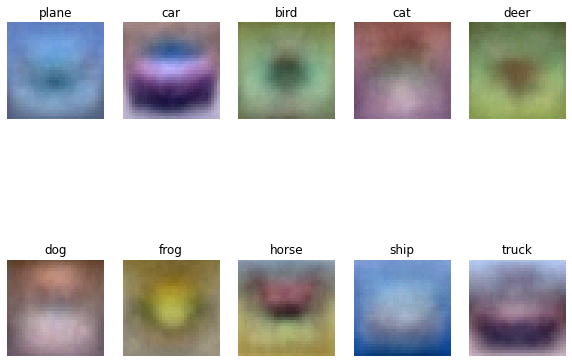

In [10]:
# 可视化学到的权重为每一个类
w = best_softmax.W[:-1,:]       # 剔除偏置
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])